In [82]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report






























from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime

import cv2
import os
import io

In [83]:
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LambdaCallback


In [84]:
from tensorboard import notebook

In [85]:
def crop_image_1(image):
    y_min = np.argmax(np.sum(image, axis=1)/image.shape[0] > 10)
    y_max = image.shape[0] - np.argmax(np.flipud(np.sum(image, axis=1)/image.shape[0] > 10))
    x_min = np.argmax(np.sum(image, axis=0)/image.shape[1] > 10)
    x_max = image.shape[1] - np.argmax(np.flipud(np.sum(image, axis=0)/image.shape[1] > 10))
    xd = x_max - x_min
    yd = y_max - y_min
    if xd > yd:
        y_max = round((xd - yd) / 2) + y_max
        y_min = y_min - ((xd - yd) - round((xd - yd) / 2))
        if y_min < 0:
            y_max = y_max - y_min
            y_min = 0
        if y_max > image.shape[0]:
            y_min = y_min - (y_max - image.shape[0])
            y_max = image.shape[0]
    elif xd < yd:
        x_max = round((yd - xd) / 2) + x_max
        x_min = x_min - ((yd - xd) - round((yd - xd) / 2))
        if x_min < 0:
            x_max = x_max - x_min
            x_min = 0
        if x_max > image.shape[1]:
            x_min = x_min - (x_max - image.shape[1])
            x_max = image.shape[1]
    return image[y_min:y_max, x_min:x_max]

def crop_image_2(image):
    y_min = np.argmax(np.sum(image, axis=1)/image.shape[0] > 10)
    y_max = image.shape[0] - np.argmax(np.flipud(np.sum(image, axis=1)/image.shape[0] > 10))
    x_min = np.argmax(np.sum(image, axis=0)/image.shape[1] > 10)
    x_max = image.shape[1] - np.argmax(np.flipud(np.sum(image, axis=0)/image.shape[1] > 10))
    return image[y_min:y_max, x_min:x_max]


In [86]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('/root/autodl-tmp/archive/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = image = crop_image_2(image)
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('/root/autodl-tmp/archive/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = crop_image_2(image)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|██████████| 300/300 [00:00<00:00, 368.28it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


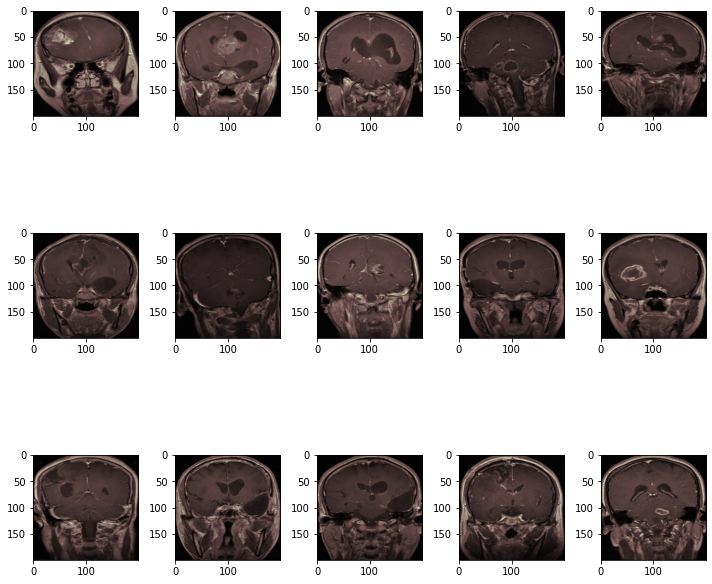

In [87]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [88]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(1143, 200, 200, 3)


In [89]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

In [90]:
net = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# 构建模型结构
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

# 编译模型
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [91]:
class_names = list(labels)
def plot_to_image(figure):    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

def plot_confusion_matrix(cm, class_names): 
    figure = plt.figure(figsize=(8, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent) 
    plt.title("Confusion matrix") 
    plt.colorbar() 
    tick_marks = np.arange(len(class_names)) 
    plt.xticks(tick_marks, class_names, rotation=45) 
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)  
    threshold = cm.max() / 2. 

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   
        color = "white" if cm[i, j] > threshold else "black"   
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)  
    
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 

    return figure

# Following function will make predictions from the model and log the confusion matrix as an image. 
def log_confusion_matrix(epoch, logs):
    predictions = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(np.argmax(y_test,axis=1), predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Remove previous log folder
!rm -fr logs
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Run tensorBoard
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [92]:
#create a writer variable for writing into the log folder.
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

#history = model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks)


# ... 其他代码 ...

# 创建一个ModelCheckpoint回调对象，指定保存模型的文件名格式
Checkpoint = ModelCheckpoint(filepath='model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.keras',
                             monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# ... 其他回调对象 ...

callbacks = [ES, RL, tensorboard, Checkpoint, LambdaCallback(on_epoch_end=log_confusion_matrix)]

history = model.fit(datagen.flow(x_train, y_train, batch_size=20),
                    validation_data=(x_val, y_val),
                    epochs=EPOCHS,
                    callbacks=callbacks)



2023-11-17 14:41:29.126404: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2023-11-17 14:41:29.126433: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2023-11-17 14:41:29.797412: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2023-11-17 14:41:29.805267: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed


Epoch 1/50
  1/229 [..............................] - ETA: 4:08 - loss: 1.6527 - accuracy: 0.1500

2023-11-17 14:41:32.745545: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2023-11-17 14:41:32.745572: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  2/229 [..............................] - ETA: 1:47 - loss: 1.5142 - accuracy: 0.2750

2023-11-17 14:41:33.271649: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-11-17 14:41:33.275273: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2023-11-17 14:41:33.317514: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 363 callback api events and 360 activity events. 
2023-11-17 14:41:33.326872: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2023-11-17 14:41:33.335055: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20231117-144127/train/plugins/profile/2023_11_17_14_41_33

2023-11-17 14:41:33.341874: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/20231117-144127/train/plugins/profile/2023_11_17_14_41_33/autodl-container-c1bc119952-d652ba34.trace.json.gz
2023-11-17 14:41:33.360966: I tensorflow/core/profiler/rpc/client/

229/229 [==============================] - 39s 166ms/step - loss: 0.7283 - accuracy: 0.7010 - val_loss: 0.4349 - val_accuracy: 0.8504

Epoch 00001: val_loss improved from inf to 0.43494, saving model to model-01-0.85-0.43.keras
Epoch 2/50
229/229 [==============================] - 36s 158ms/step - loss: 0.3614 - accuracy: 0.8777 - val_loss: 0.3626 - val_accuracy: 0.8714

Epoch 00002: val_loss improved from 0.43494 to 0.36259, saving model to model-02-0.87-0.36.keras
Epoch 3/50
229/229 [==============================] - 36s 157ms/step - loss: 0.2346 - accuracy: 0.9184 - val_loss: 0.1907 - val_accuracy: 0.9353

Epoch 00003: val_loss improved from 0.36259 to 0.19072, saving model to model-03-0.94-0.19.keras
Epoch 4/50
229/229 [==============================] - 36s 158ms/step - loss: 0.1851 - accuracy: 0.9376 - val_loss: 0.1394 - val_accuracy: 0.9545

Epoch 00004: val_loss improved from 0.19072 to 0.13939, saving model to model-04-0.95-0.14.keras
Epoch 5/50
229/229 [=======================

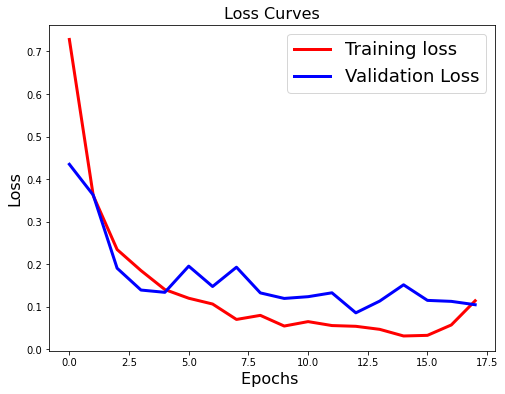

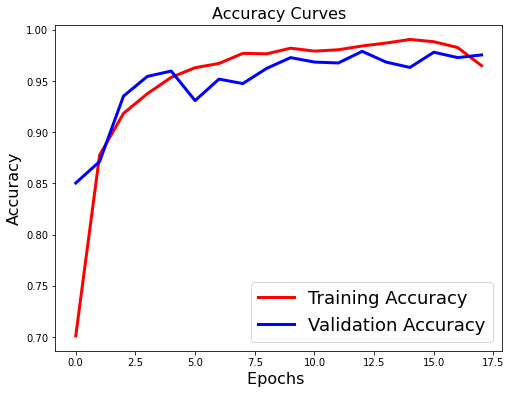

In [93]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()
     

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       300
           1       0.94      0.98      0.96       306
           2       0.99      0.99      0.99       405
           3       1.00      0.98      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



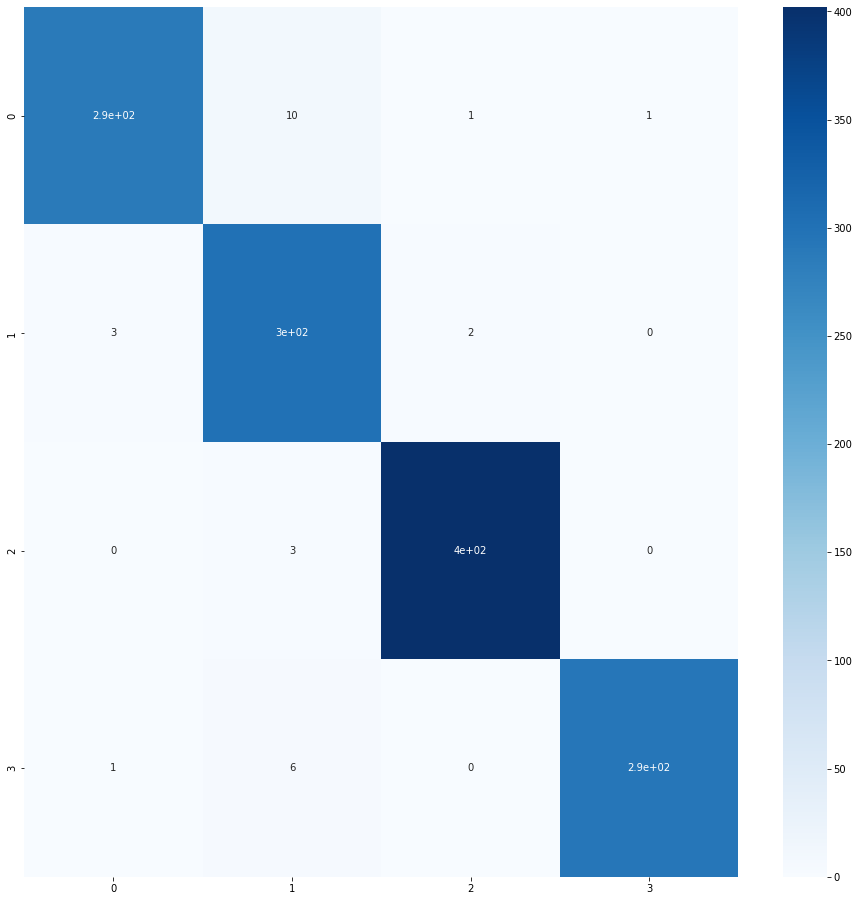

In [94]:
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))
     

In [95]:
loss,acc = model.evaluate(x_test,y_test)

41/41 [==============================] - 2s 53ms/step - loss: 0.0789 - accuracy: 0.9794
